An example of using the scheduler and speedObservatory to run a 1-filter survey

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from lsst.sims.featureScheduler import Core_scheduler
from lsst.sims.featureScheduler.utils import generate_goal_map, calc_norm_factor, sim_runner
import healpy as hp
import lsst.sims.featureScheduler.basis_functions as basis_functions
import lsst.sims.featureScheduler.surveys as surveys
from lsst.sims.speedObservatory import Speed_observatory

In [2]:
# Set the resolution for all the healpix maps
nside = 32
# The single filter we will use
filtername = 'r'

In [3]:
# Define the ratio of visits we would like across the sky
target_map = generate_goal_map(NES_fraction=0.46,
                                  WFD_fraction=1.0, SCP_fraction=0.15,
                                  WFD_upper_edge_fraction = 0,
                                  GP_fraction=0.15, nside=nside,
                                  generate_id_map=False)
# What we need to normalize the map by
norm_factor = calc_norm_factor({'dummy': target_map})

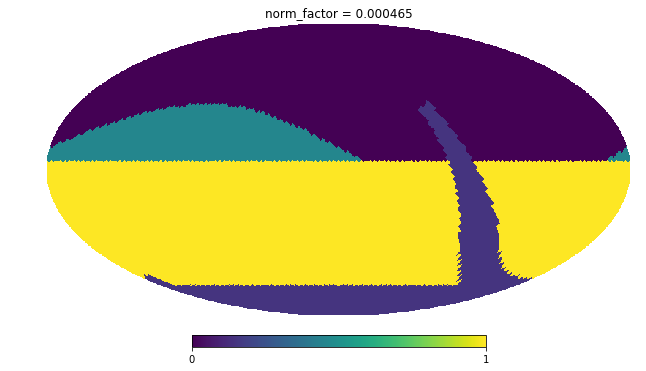

In [4]:
#Let's look at the survey we are going to try and make
hp.mollview(target_map, title='norm_factor = %f' % norm_factor)

In [5]:
# Now to make a list of basis functions that we will use
bfs = []
# We will consider the 5-sigma limiting depth
bfs.append(basis_functions.M5_diff_basis_function(filtername=filtername, nside=nside))
# How well we are doing compared to our target map
bfs.append(basis_functions.Target_map_basis_function(filtername=filtername,
                                         target_map=target_map,
                                         out_of_bounds_val=hp.UNSEEN, nside=nside,
                                         norm_factor=norm_factor))
# The slewtime
bfs.append(basis_functions.Slewtime_basis_function(filtername=filtername, nside=nside))
# Masks, give these 0 weight
bfs.append(basis_functions.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
bfs.append(basis_functions.Moon_avoidance_basis_function(nside=nside, moon_distance=30.))
bfs.append(basis_functions.Bulk_cloud_basis_function(nside=nside, max_val=0.7))
# Assign a weight to each basis function
weights = np.array([3., 0.3, 1., 0., 0., 0.])


In [6]:
# Now to make a survey object with our list of basis functions
survey = surveys.Greedy_survey(bfs, weights, nside=nside, block_size=1)

# Make the scheduler object
scheduler = Core_scheduler([survey], nside=nside)

In [7]:
# A model observatory
observatory = Speed_observatory()

In [8]:
survey_length = 2.5
observatory, scheduler, observations = sim_runner(observatory, scheduler,
                                                  survey_length=survey_length,
                                                  filename=None)

/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


progress = 99.6%Skipped 0 observations
Completed 1725 observations


In [9]:
# grab the current conditions from the scheduler
conditions = scheduler.conditions

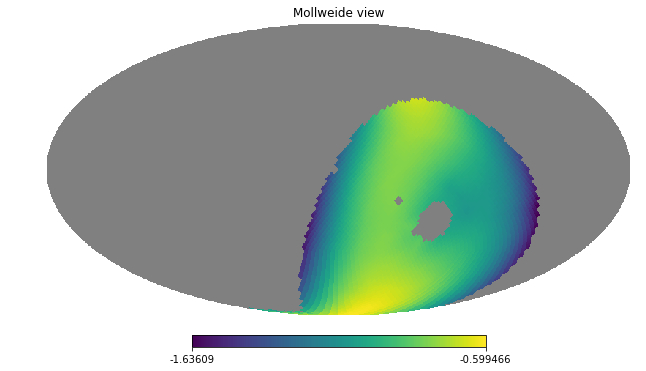

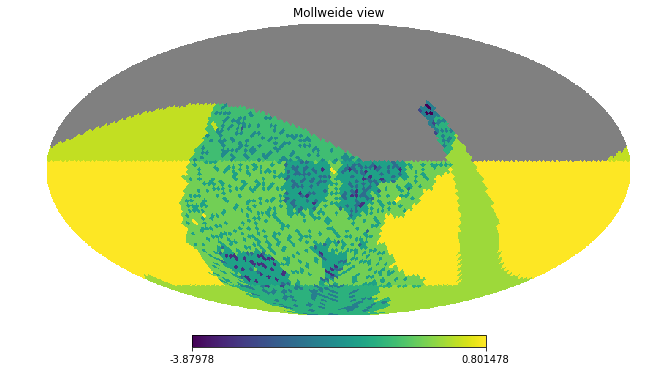

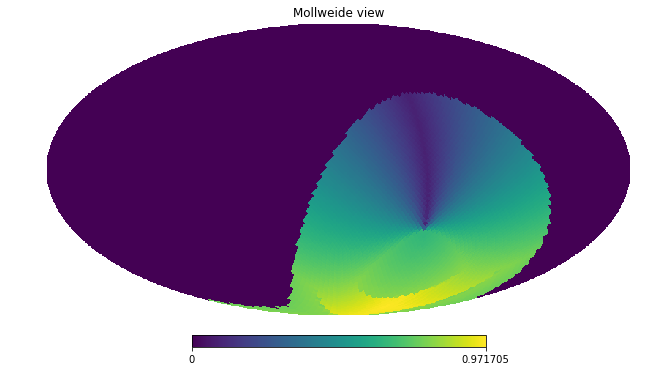

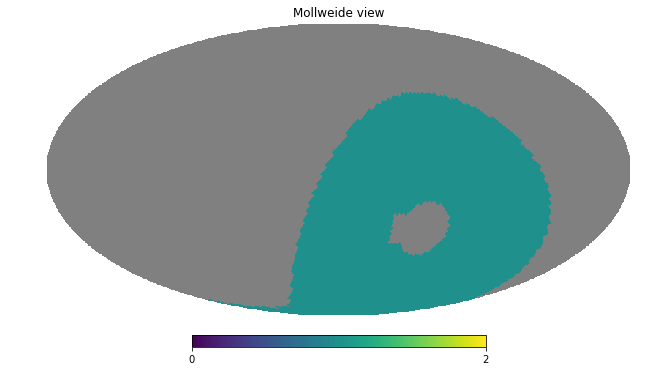

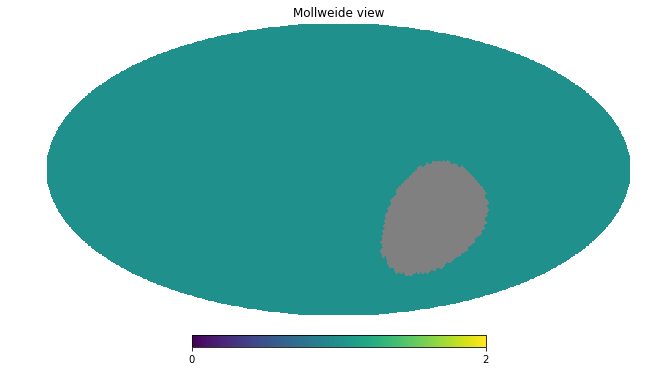

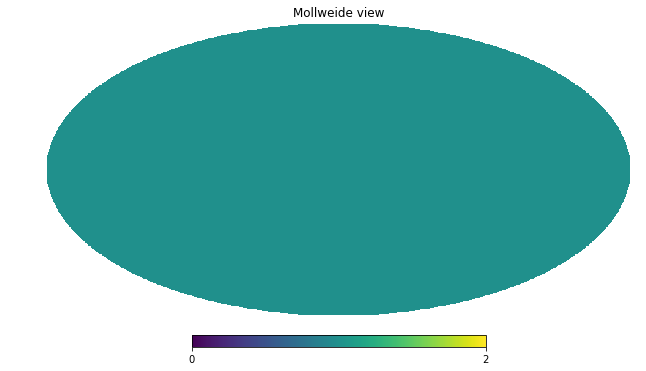

In [10]:
# Let's see what the basis functions look like
for bf in bfs:
    hp.mollview(bf(conditions))

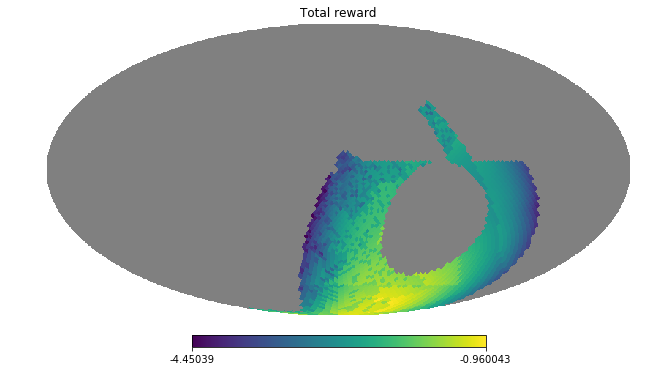

In [11]:
# And those basis fucntions combine to make the following reward function
hp.mollview(survey.calc_reward_function(conditions), title='Total reward')

In [12]:
# So we can see that moon exclusion zone can really knock a lot of sky out of bounds.

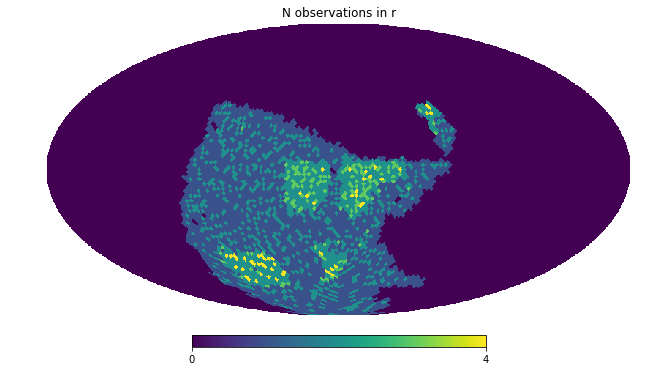

In [13]:
# We can reach into the basis functions and look at the feature tracking the number of observations take
hp.mollview(bfs[1].survey_features['N_obs'].feature, title='N observations in %s' % bfs[1].survey_features['N_obs'].filtername)